## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [32]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [33]:
## Import Keras objects for Deep Learning

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [34]:

## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin",
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [35]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
# diabetes_df.sample(5)

(768, 9)


In [36]:
diabetes_df.head()

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
X = diabetes_df.iloc[:, :-1].values #train features
y = diabetes_df["has_diabetes"].values

In [38]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [39]:
# Split the data to Train, and Test (75%, 25%)
# stratify คือ การกำหนดการกระจายของข้อมูลที่ split ให้มีการกระจายเหมือน original dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)

In [40]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [41]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=seed_value)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=11111)

In [42]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.795


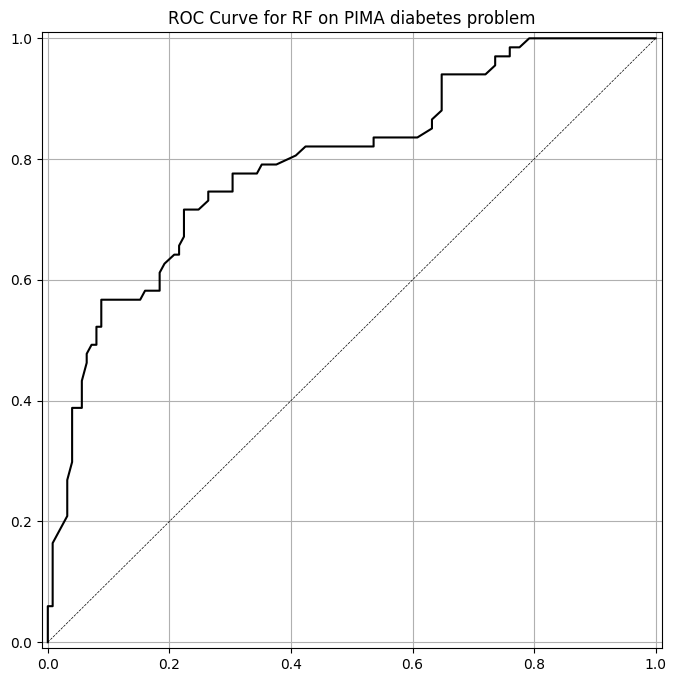

In [43]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 8 nodes.

In [44]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [45]:
X_train_norm

array([[-1.17553013, -0.88319193, -0.4797748 , ..., -0.41547152,
         0.23300528, -0.95829939],
       [-1.17553013, -1.35145275,  0.9447112 , ...,  0.60441055,
        -0.07457346, -1.04227634],
       [-0.58157806, -0.50858328, -0.5815238 , ...,  0.35565882,
        -0.73053221, -0.70636856],
       ...,
       [ 0.60632606, -0.1964094 , -0.4797748 , ...,  0.20640779,
        -0.66776104,  0.55328559],
       [-0.87855409,  0.86498179, -0.0727788 , ..., -0.340846  ,
        -0.34135094,  0.72123948],
       [ 1.49725416,  0.95863395,  0.4359662 , ...,  0.26859572,
         1.36602495, -0.03455301]])

In [46]:
X_test_norm

array([[ 0.012374  ,  1.02106873,  0.1307192 , ..., -0.09209428,
        -0.37587509,  0.30135476],
       [ 1.79423019,  0.36550358, -0.0727788 , ..., -0.62691048,
        -0.66776104,  0.21737782],
       [-0.58157806,  1.64541648,  0.9447112 , ...,  1.54966709,
         0.59080097, -0.79034551],
       ...,
       [ 0.012374  , -0.78953977, -0.6832728 , ..., -1.39804083,
        -0.36959797, -0.62239162],
       [-0.87855409, -0.29006156,  0.1307192 , ...,  0.29347089,
         0.22045105, -0.70636856],
       [ 0.9033021 , -0.47736589, -0.4797748 , ..., -0.68909841,
        -0.50769455, -0.37046079]])

In [47]:
# Define the Model
# Input size is 8-dimensional
# 1 hidden layer, 8 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

import os, random, numpy as np
import tensorflow as tf

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

model_1 = Sequential([
    Dense(8, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [48]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Comprehension question:
Why do we have 81 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [49]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200, batch_size=32)
# the fit function returns the run history.
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 1s 12ms/step - loss: 0.8103 - accuracy: 0.4983 - val_loss: 0.7811 - val_accuracy: 0.4844
Epoch 2/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7961 - accuracy: 0.5069 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 3/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7828 - accuracy: 0.5260 - val_loss: 0.7536 - val_accuracy: 0.5052
Epoch 4/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7703 - accuracy: 0.5399 - val_loss: 0.7412 - val_accuracy: 0.5052
Epoch 5/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7585 - accuracy: 0.5503 - val_loss: 0.7295 - val_accuracy: 0.5365
Epoch 6/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7475 - accuracy: 0.5556 - val_loss: 0.7186 - val_accuracy: 0.5573
Epoch 7/200
18/18 [==============================] - 0s 6ms/step - loss: 0.7371 - accuracy: 0.5712 - val_loss: 0.7083 - val_accuracy: 0.5885
Epoch 8/200


In [50]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 [==============================] - 0s 2ms/step


In [51]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [52]:
y_pred_prob_nn_1[:10]

array([[0.544924  ],
       [0.46085215],
       [0.78104424],
       [0.15001746],
       [0.39762586],
       [0.8129517 ],
       [0.6315116 ],
       [0.15228054],
       [0.11431644],
       [0.95573366]], dtype=float32)

accuracy is 0.745
roc-auc is 0.817


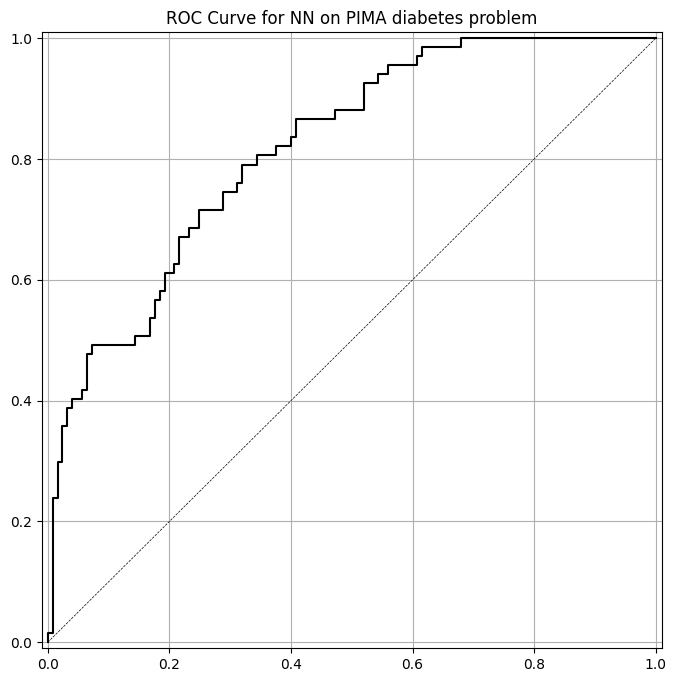

In [53]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [54]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

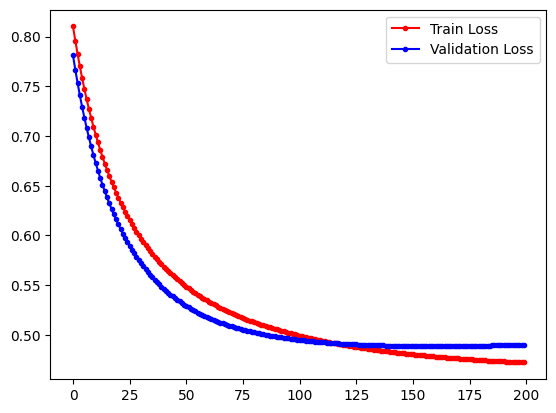

In [55]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [56]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, batch_size=32)

Epoch 1/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4720 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7448
Epoch 2/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4719 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7448
Epoch 3/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4718 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7448
Epoch 4/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4716 - accuracy: 0.7760 - val_loss: 0.4900 - val_accuracy: 0.7448
Epoch 5/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4716 - accuracy: 0.7760 - val_loss: 0.4900 - val_accuracy: 0.7448
Epoch 6/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4715 - accuracy: 0.7760 - val_loss: 0.4901 - val_accuracy: 0.7448
Epoch 7/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.4714 - accuracy: 0.7760 - val_loss: 0.4901 - val_accuracy: 0.7448
Epoch 

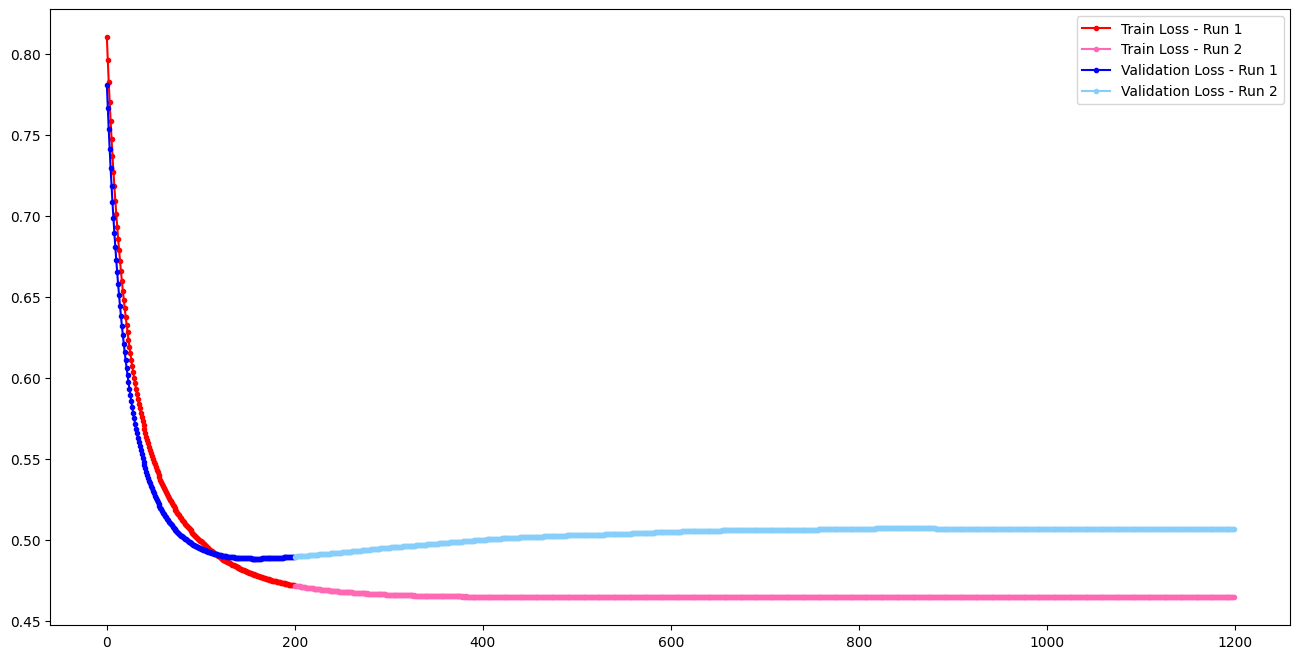

In [57]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history
 ["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

**Student Answer:**

---
จากกราฟ n epoh ที่เหมาะสม คือ 200 เพราะมากกว่านี้  validation loss ก็ไม่ขยับลงแล้ว

# <span style="color:blue">แบบฝึกปฏิบัติ</span>

(รวม 100 คะแนน) ให้นิสิตใช้พื้นที่ต่อไปนี้ ในการเพิ่มโค้ดให้เป็นไปตามข้อกำหนดต่อไปนี้
1. (50 คะแนน) เพิ่มเซลโค้ด เพื่อ
   * สร้างโมเดลที่มีเลเยอร์ hidden 2 ชั้น แต่ละชั้นมี 6 โหนด
   * ปรับโค้ดให้สามารถรับอินพุตที่มีจำนวน feature ตามข้อมูลเทรนที่จะถูกส่งเข้ามา (ปราศจากการใช้ค่าคงที่ 8 ที่ถูกระบุอยู่ในโค้ด ณ ตอนนี้)
   * สำหรับเลเยอร์ hidden ให้ใช้ activation function เป็น "relu" และเลเยอร์ output เป็น "sigmoid"
   * ใช้ learning rate เท่ากับ 0.003 และเทรนด้วยจำนวน 1500 epochs ส่วนสำหรับ Hyperparameter ที่เหลือให้ใช้ค่าคงเดิม
   * วาดกราฟของค่า loss และ accuracy ด้วยทั้งชุดข้อมูล train และ test (ดังตัวอย่างในรูปนี้)
  <img src="https://drive.google.com/uc?id=1GuN0KQf64rGMa4oCY2upnbOTMzWaXmbT" style="height:360px">
2. (50 คะแนน) เพิ่มอีกเซลโค้ด เพื่อสร้างโมเดลที่มีการปรับโครงสร้างที่เหมาะสมขึ้น รวมถึงการปรับค่า Hyperparameter ต่าง ๆ เพื่อให้โมเดลใหม่ได้ผลลัพธ์ที่ดีขึ้น (โดยพิจารณาจากค่า accuracy) และในการเทรนโมเดลใหม่นี้ ห้ามมีการใช้ Early Stopping
   * ให้วาดกราฟของค่า loss และ accuracy ของโมเดลใหม่นี้ด้วย
   * อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม

ข้อ 1

In [58]:
X_train_norm.shape

(576, 8)

In [59]:
model_1n = Sequential([
    Dense(6, input_shape=X_train_norm.shape[1:], activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [60]:
model_1n.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
 dense_8 (Dense)             (None, 6)                 42        
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 103 (412.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# compile new_model_1
model_1n.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

In [62]:
run_hist_model_1n = model_1n.fit(X_train_norm, y_train, validation_data=(X_test_norm,y_test), epochs=1500, batch_size=32)

Epoch 1/1500


2023-12-20 20:53:01.729863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


18/18 [==============================] - 0s 12ms/step - loss: 0.6078 - accuracy: 0.6979 - val_loss: 0.6129 - val_accuracy: 0.7083
Epoch 2/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.6044 - accuracy: 0.6944 - val_loss: 0.6100 - val_accuracy: 0.7135
Epoch 3/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.6011 - accuracy: 0.6962 - val_loss: 0.6072 - val_accuracy: 0.7240
Epoch 4/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.5979 - accuracy: 0.6979 - val_loss: 0.6045 - val_accuracy: 0.7240
Epoch 5/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.5948 - accuracy: 0.6979 - val_loss: 0.6020 - val_accuracy: 0.7240
Epoch 6/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.5918 - accuracy: 0.7049 - val_loss: 0.5995 - val_accuracy: 0.7240
Epoch 7/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.5890 - accuracy: 0.7118 - val_loss: 0.5972 - val_accuracy: 0.7240
Epoch 8/1500
18/18

In [63]:
y_pred_prob_model_1n = model_1n.predict(X_test_norm)
y_pred_class_model_1n = (y_pred_prob_model_1n >= 0.5).astype("int32")

6/6 [==============================] - 0s 2ms/step


In [64]:
y_pred_prob_model_1n[:10]

array([[0.5020608 ],
       [0.5332957 ],
       [0.818219  ],
       [0.11957027],
       [0.40156677],
       [0.82637817],
       [0.678211  ],
       [0.1170831 ],
       [0.09943931],
       [0.98141956]], dtype=float32)

In [65]:
y_pred_class_model_1n[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

accuracy is 0.745
roc-auc is 0.801


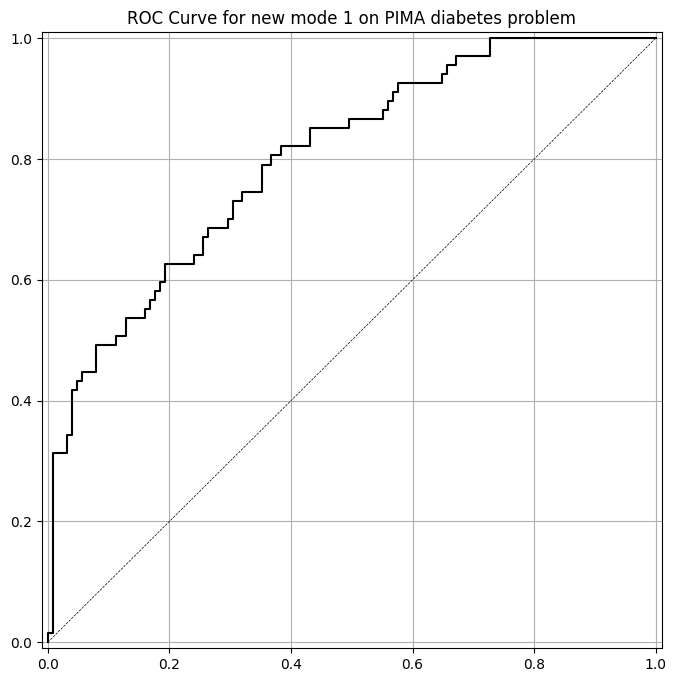

In [66]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_model_1n)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_model_1n)))

plot_roc(y_test, y_pred_prob_model_1n, 'new mode 1')

In [67]:
run_hist_model_1n.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

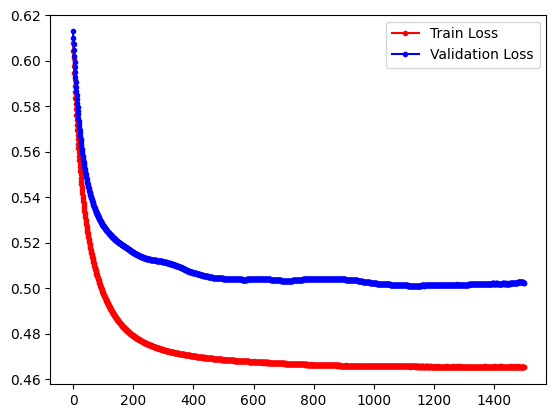

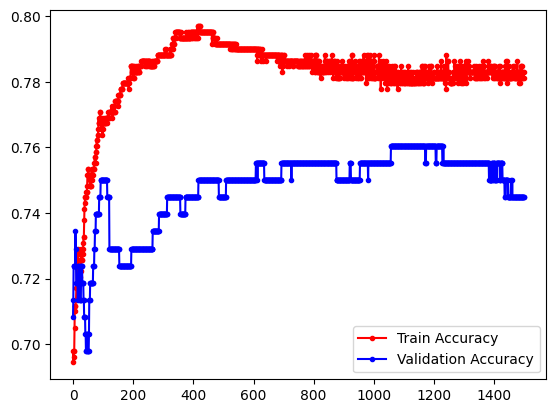

In [68]:
fig, ax = plt.subplots()
ax.plot(run_hist_model_1n.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_model_1n.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

fig, ay = plt.subplots()
ay.plot(run_hist_model_1n.history["accuracy"],'r', marker='.', label="Train Accuracy")
ay.plot(run_hist_model_1n.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ay.legend()

ข้อ 2

In [69]:
model_1nc = Sequential([
    Dense(6, input_shape=X_train_norm.shape[1:], activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_1nc.summary()
# compile new_model_1
model_1nc.compile(optimizer=SGD(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6)                 54        
                                                                 
 dense_11 (Dense)            (None, 6)                 42        
                                                                 
 dense_12 (Dense)            (None, 1)                 7         
                                                                 
Total params: 103 (412.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
run_hist_model_1nc = model_1nc.fit(X_train_norm, y_train, validation_data=(X_test_norm,y_test), epochs=1500, batch_size=32)

Epoch 1/1500


2023-12-20 20:55:49.846691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


18/18 [==============================] - 0s 12ms/step - loss: 0.8244 - accuracy: 0.3872 - val_loss: 0.7535 - val_accuracy: 0.4427
Epoch 2/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.8002 - accuracy: 0.4080 - val_loss: 0.7348 - val_accuracy: 0.4583
Epoch 3/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7793 - accuracy: 0.4201 - val_loss: 0.7182 - val_accuracy: 0.4948
Epoch 4/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7596 - accuracy: 0.4358 - val_loss: 0.7034 - val_accuracy: 0.5208
Epoch 5/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7426 - accuracy: 0.4583 - val_loss: 0.6904 - val_accuracy: 0.5469
Epoch 6/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7272 - accuracy: 0.4861 - val_loss: 0.6788 - val_accuracy: 0.5625
Epoch 7/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7132 - accuracy: 0.5156 - val_loss: 0.6683 - val_accuracy: 0.5677
Epoch 8/1500
18/18

In [71]:
y_pred_prob_model_1nc= model_1nc.predict(X_test_norm)
y_pred_class_model_1nc = (y_pred_prob_model_1nc >= 0.5).astype("int32")

6/6 [==============================] - 0s 2ms/step


accuracy is 0.729
roc-auc is 0.804


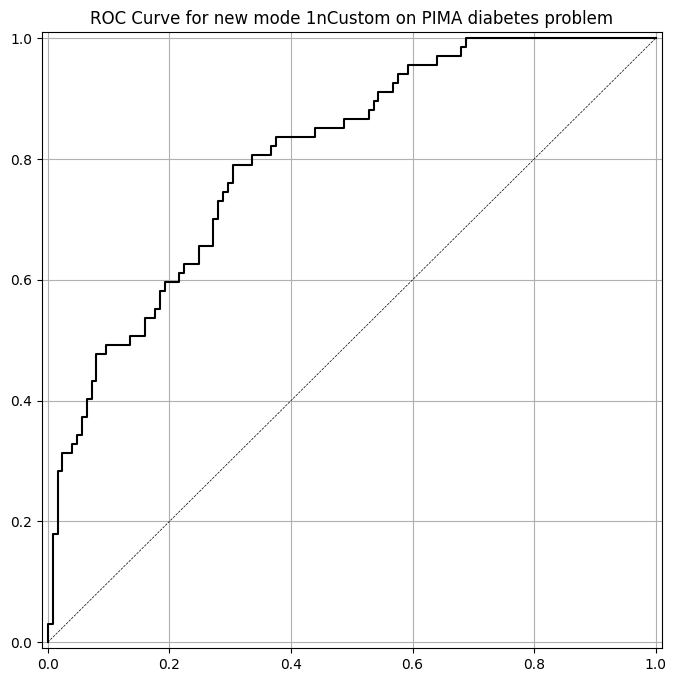

In [72]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_model_1nc)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_model_1nc)))

plot_roc(y_test, y_pred_prob_model_1nc, 'new mode 1nCustom')

In [73]:
run_hist_model_1nc.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

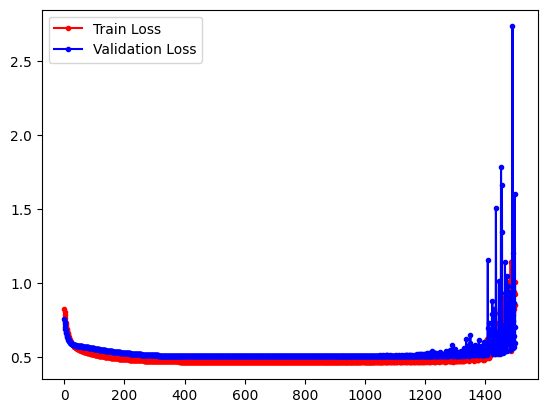

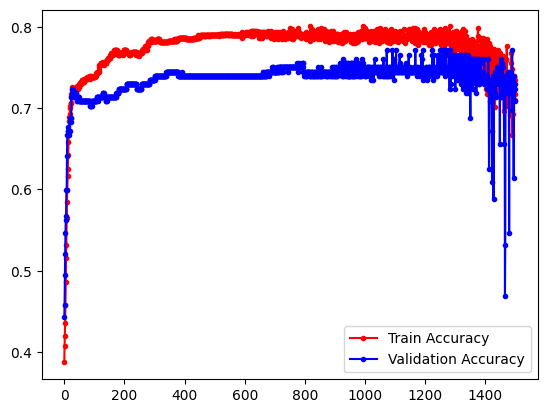

In [74]:
fig, ax = plt.subplots()
ax.plot(run_hist_model_1nc.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_model_1nc.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

fig, ay = plt.subplots()
ay.plot(run_hist_model_1nc.history["accuracy"],'r', marker='.', label="Train Accuracy")
ay.plot(run_hist_model_1nc.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ay.legend()